In [2]:
import glob
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon

In [3]:
%matplotlib inline
pd.set_option('display.max_columns', 500)
tqdm.pandas()

## Import the data

Wave I, the main survey, was fielded between February 21 and April 2, 2009. Wave 2 was fielded March 12, 2010 to June 8, 2010. Wave 3 was fielded March 22, 2011 to August 29, 2011. Wave 4 was fielded between March and November of 2013. Wave 5 was fielded between November, 2014 and March, 2015. Dates for the background demographic surveys are described in the User's Guide, under documentation below.

In [4]:
df_w3 = pd.read_stata('wave_3.dta')
df_w4 = pd.read_stata('wave_4.dta')
df_w5 = pd.read_stata('wave_5.dta')

In [5]:
df_w3.shape

(4002, 387)

In [6]:
df_w3[df_w3['q24_vacation'] == 'Yes']

,caseid_new,weight1,weight2,ppage,ppagecat,ppagect4,ppeduc,ppeducat,ppethm,ppgender,pphhhead,pphouseholdsize,pphouse,ppincimp,hhinc,ppmarit,ppmsacat,ppreg4,ppreg9,pprent,ppt01,ppt1317,ppt18ov,ppt25,ppt612,children_in_hh,ppwork,ppnet,ppq14arace,pphispan,pprace_white,pprace_black,pprace_nativeamerican,pprace_asianindian,pprace_chinese,pprace_filipino,pprace_japanese,pprace_korean,pprace_vietnamese,pprace_otherasian,pprace_hawaiian,pprace_guamanian,pprace_samoan,pprace_otherpacificislander,pprace_someotherrace,papglb_friend,pppartyid3,papevangelical,papreligion,ppppcmdate_yrmo,pppadate_yrmo,pphhcomp11_member2_age,pphhcomp11_member3_age,pphhcomp11_member4_age,pphhcomp11_member5_age,pphhcomp11_member6_age,pphhcomp11_member7_age,pphhcomp11_member8_age,pphhcomp11_member9_age,pphhcomp11_member10_age,pphhcomp11_member11_age,pphhcomp11_member12_age,pphhcomp11_member13_age,pphhcomp11_member14_age,pphhcomp11_member15_age,pphhcomp11_member2_gender,pphhcomp11_member3_gender,pphhcomp11_member4_gender,pphhcomp11_member5_gender,pphhcomp11_member6_gender,pphhcomp11_member7_gender,pphhcomp11_member8_gender,pphhcomp11_member9_gender,pphhcomp11_member10_gender,pphhcomp11_member11_gender,pphhcomp11_member12_gender,pphhcomp11_member13_gender,pphhcomp11_member14_gender,pphhcomp11_member15_gender,pphhcomp11_member2_relationship,pphhcomp11_member3_relationship,pphhcomp11_member4_relationship,pphhcomp11_member5_relationship,pphhcomp11_member6_relationship,pphhcomp11_member7_relationship,pphhcomp11_member8_relationship,pphhcomp11_member9_relationship,pphhcomp11_member10_relationship,pphhcomp11_member11_relationship,pphhcomp11_member12_relationship,pphhcomp11_member13_relationship,pphhcomp11_member14_relationship,pphhcomp11_member15_relationship,irb_consent,weight3,weight4,weight5,weight6,weight7,weight_couples_coresident,HCMST_main_interview_yrmo,duration,qflag,glbstatus,papglb_status,recsource,s1,s1a,s2,q3_codes,q4,q5,q6a,q6b,q7a,q7b,q8a,q8b,q9,q10,q11,q12,q13a,q13b,q14,q15a1_compressed,q16,q17a,q17b,q17c,q17d,gender_attraction,q18a_1,q18a_2,q18a_3,q18a_refused,q18b_codes,q18c_codes,q19,q20,q21a,q21a_refusal,q21b,q21b_refusal,q21c,q21c_refusal,q21d,q21d_refusal,q21e,q21e_refusal,q22,q23,q24_codes,q25,q26,q27,q28,q29,q30,q31_1,q31_2,q31_3,q31_4,q31_5,q31_6,q31_7,q31_8,q31_9,q31_other_text_entered,q32,q33_1,q33_2,q33_3,q33_4,q33_5,q33_6,q33_7,q33_other_text_entered,q34,q35_codes,q35_text_entered,q24_met_online,summary_q24_total,q24_R_cowork,q24_R_friend,q24_R_family,q24_R_sig_other,q24_R_neighbor,q24_P_cowork,q24_P_friend,q24_P_family,q24_P_sig_other,q24_P_neighbor,q24_btwn_I_cowork,q24_btwn_I_friend,q24_btwn_I_family,q24_btwn_I_sig_other,q24_btwn_I_neighbor,q24_school,q24_college,q24_military,q24_church,q24_vol_org,q24_customer,q24_bar_restaurant,q24_internet_dating,q24_internet_social_networking,q24_internet_game,q24_internet_chat,q24_internet_community,q24_internet_other,q24_public,q24_private_party,q24_blind_date,q24_vacation,q24_singles_service_non_internet,q24_business_trip,q24_work_neighbor,q24_fam_sister_active,q24_fam_brother_active,q24_fam_mother_active,q24_fam_father_active,q24_fam_other_active,q24_fam_cousins_active,q24_fam_aunt_niece_active,q24_fam_uncle_nephew_active,q24_fam_grandmother_active,q24_fam_grandfather_active,q24_fam_sister_passive,q24_fam_brother_passive,q24_fam_mother_passive,q24_fam_father_passive,q24_fam_other_passive,q24_fam_cousins_passive,q24_fam_aunt_niece_passive,q24_fam_uncle_nephew_passive,q24_fam_grandmother_passive,q24_fam_grandfather_passive,q24_fam_female,q24_fam_male,distancemoved_10mi,marrynotreally,marrycountry,civilnotreally,partner_deceased,partner_religion_reclassified,partner_religion_child_reclass,own_religion_child_reclass,q32_internet,how_met_online,either_internet,either_internet_adjusted,same_sex_couple,potential_partner_gender_recodes,alt_partner_gender,how_long_ago_first_met,how_long_ago_first_romantic,how_long_ago_first_cohab,how_long_ago_first_met_cat,how_long_relationship,respondent_race,partner_rac

In [97]:
df_w3['summary_q24_total'].value_counts()

2.0    902
1.0    873
3.0    681
4.0    322
5.0    109
6.0     32
0.0      7
7.0      6
8.0      2
Name: summary_q24_total, dtype: int64

In [14]:
# Q24. Please write the story of how you and [Partner_Name] first met and got to know
# one another and be sure to describe "how" and "where" you first met. 
q24_list = ["caseid_new", "q24_met_online","summary_q24_total","q24_R_cowork","q24_R_friend","q24_R_family","q24_R_sig_other","q24_R_neighbor","q24_P_cowork","q24_P_friend","q24_P_family","q24_P_sig_other","q24_P_neighbor","q24_btwn_I_cowork","q24_btwn_I_friend","q24_btwn_I_family","q24_btwn_I_sig_other","q24_btwn_I_neighbor","q24_school","q24_college","q24_military","q24_church","q24_vol_org","q24_customer","q24_bar_restaurant","q24_internet_dating","q24_internet_social_networking","q24_internet_game","q24_internet_chat","q24_internet_community","q24_internet_other","q24_public","q24_private_party","q24_blind_date","q24_vacation","q24_singles_service_non_internet","q24_business_trip","q24_work_neighbor","q24_fam_sister_active","q24_fam_brother_active","q24_fam_mother_active","q24_fam_father_active","q24_fam_other_active","q24_fam_cousins_active","q24_fam_aunt_niece_active","q24_fam_uncle_nephew_active","q24_fam_grandmother_active","q24_fam_grandfather_active","q24_fam_sister_passive","q24_fam_brother_passive","q24_fam_mother_passive","q24_fam_father_passive","q24_fam_other_passive","q24_fam_cousins_passive","q24_fam_aunt_niece_passive","q24_fam_uncle_nephew_passive","q24_fam_grandmother_passive","q24_fam_grandfather_passive","q24_fam_female","q24_fam_male"]
df_w3_q24 = df_w3[q24_list]

In [19]:
df_w3_q24.head()

,caseid_new,q24_met_online,summary_q24_total,q24_R_cowork,q24_R_friend,q24_R_family,q24_R_sig_other,q24_R_neighbor,q24_P_cowork,q24_P_friend,q24_P_family,q24_P_sig_other,q24_P_neighbor,q24_btwn_I_cowork,q24_btwn_I_friend,q24_btwn_I_family,q24_btwn_I_sig_other,q24_btwn_I_neighbor,q24_school,q24_college,q24_military,q24_church,q24_vol_org,q24_customer,q24_bar_restaurant,q24_internet_dating,q24_internet_social_networking,q24_internet_game,q24_internet_chat,q24_internet_community,q24_internet_other,q24_public,q24_private_party,q24_blind_date,q24_vacation,q24_singles_service_non_internet,q24_business_trip,q24_work_neighbor,q24_fam_sister_active,q24_fam_brother_active,q24_fam_mother_active,q24_fam_father_active,q24_fam_other_active,q24_fam_cousins_active,q24_fam_aunt_niece_active,q24_fam_uncle_nephew_active,q24_fam_grandmother_active,q24_fam_grandfather_active,q24_fam_sister_passive,q24_fam_brother_passive,q24_fam_mother_passive,q24_fam_father_passive,q24_fam_other_passive,q24_fam_cousins_passive,q24_fam_aunt_niece_passive,q24_fam_uncle_nephew_passive,q24_fam_grandmother_passive,q24_fam_grandfather_passive,q24_fam_female,q24_fam_male
0,22526,met online,2.0,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
1,23286,met offline,4.0,No,Yes,No,No,Yes,No,Yes,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
2,25495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26315,met online,3.0,No,Yes,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
4,27355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_w3_q24_melted = df_w3_q24.melt(var_name='question', value_name='answer', id_vars=['caseid_new'])

In [55]:
how_met = df_w3_q24_melted.groupby('question')['answer'].value_counts(normalize=True).reset_index(name='count')
how_met['answer'].replace(['No', 'Nan', 'NaN', '', 'nan'], 'No', inplace=True)
how_met['answer'].replace(['met offline'], 'No', inplace=True)
how_met['answer'].replace(['met online'], 'Yes', inplace=True)
how_met.head()

,question,answer,count
0,q24_P_cowork,No,0.854124
1,q24_P_cowork,Yes,0.145876
2,q24_P_family,No,0.911725
3,q24_P_family,Yes,0.088275
4,q24_P_friend,No,0.737219


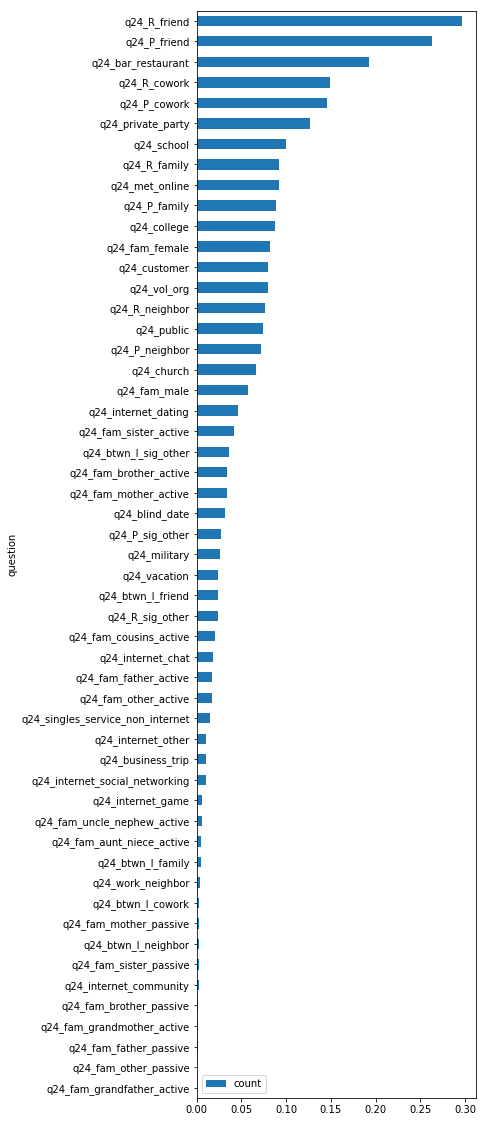

In [61]:
how_met[how_met['answer'] == 'Yes'].sort_values(by='count').plot(kind='barh', y='count', x='question', figsize=(5,20))

In [91]:
df_w3['how_long_relationship'].max()

76.0

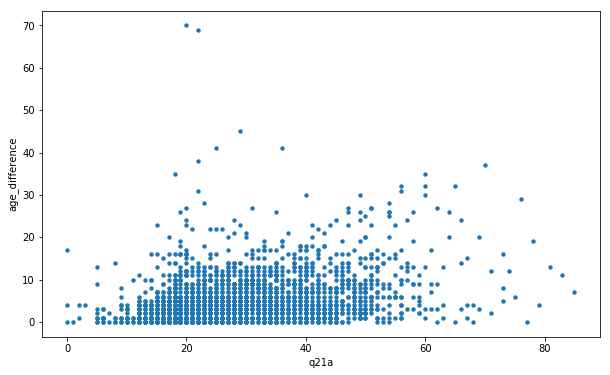

In [96]:
df_w3.plot(x='q21a',  # mariage age
        y='age_difference', 
        kind='scatter', 
        #xlim=(0, 100), 
        #ylim=(0, 100), 
        linewidth=0, 
        figsize=(10,6))

In [52]:
df_w3.head()

,caseid_new,weight1,weight2,ppage,ppagecat,ppagect4,ppeduc,ppeducat,ppethm,ppgender,pphhhead,pphouseholdsize,pphouse,ppincimp,hhinc,ppmarit,ppmsacat,ppreg4,ppreg9,pprent,ppt01,ppt1317,ppt18ov,ppt25,ppt612,children_in_hh,ppwork,ppnet,ppq14arace,pphispan,pprace_white,pprace_black,pprace_nativeamerican,pprace_asianindian,pprace_chinese,pprace_filipino,pprace_japanese,pprace_korean,pprace_vietnamese,pprace_otherasian,pprace_hawaiian,pprace_guamanian,pprace_samoan,pprace_otherpacificislander,pprace_someotherrace,papglb_friend,pppartyid3,papevangelical,papreligion,ppppcmdate_yrmo,pppadate_yrmo,pphhcomp11_member2_age,pphhcomp11_member3_age,pphhcomp11_member4_age,pphhcomp11_member5_age,pphhcomp11_member6_age,pphhcomp11_member7_age,pphhcomp11_member8_age,pphhcomp11_member9_age,pphhcomp11_member10_age,pphhcomp11_member11_age,pphhcomp11_member12_age,pphhcomp11_member13_age,pphhcomp11_member14_age,pphhcomp11_member15_age,pphhcomp11_member2_gender,pphhcomp11_member3_gender,pphhcomp11_member4_gender,pphhcomp11_member5_gender,pphhcomp11_member6_gender,pphhcomp11_member7_gender,pphhcomp11_member8_gender,pphhcomp11_member9_gender,pphhcomp11_member10_gender,pphhcomp11_member11_gender,pphhcomp11_member12_gender,pphhcomp11_member13_gender,pphhcomp11_member14_gender,pphhcomp11_member15_gender,pphhcomp11_member2_relationship,pphhcomp11_member3_relationship,pphhcomp11_member4_relationship,pphhcomp11_member5_relationship,pphhcomp11_member6_relationship,pphhcomp11_member7_relationship,pphhcomp11_member8_relationship,pphhcomp11_member9_relationship,pphhcomp11_member10_relationship,pphhcomp11_member11_relationship,pphhcomp11_member12_relationship,pphhcomp11_member13_relationship,pphhcomp11_member14_relationship,pphhcomp11_member15_relationship,irb_consent,weight3,weight4,weight5,weight6,weight7,weight_couples_coresident,HCMST_main_interview_yrmo,duration,qflag,glbstatus,papglb_status,recsource,s1,s1a,s2,q3_codes,q4,q5,q6a,q6b,q7a,q7b,q8a,q8b,q9,q10,q11,q12,q13a,q13b,q14,q15a1_compressed,q16,q17a,q17b,q17c,q17d,gender_attraction,q18a_1,q18a_2,q18a_3,q18a_refused,q18b_codes,q18c_codes,q19,q20,q21a,q21a_refusal,q21b,q21b_refusal,q21c,q21c_refusal,q21d,q21d_refusal,q21e,q21e_refusal,q22,q23,q24_codes,q25,q26,q27,q28,q29,q30,q31_1,q31_2,q31_3,q31_4,q31_5,q31_6,q31_7,q31_8,q31_9,q31_other_text_entered,q32,q33_1,q33_2,q33_3,q33_4,q33_5,q33_6,q33_7,q33_other_text_entered,q34,q35_codes,q35_text_entered,q24_met_online,summary_q24_total,q24_R_cowork,q24_R_friend,q24_R_family,q24_R_sig_other,q24_R_neighbor,q24_P_cowork,q24_P_friend,q24_P_family,q24_P_sig_other,q24_P_neighbor,q24_btwn_I_cowork,q24_btwn_I_friend,q24_btwn_I_family,q24_btwn_I_sig_other,q24_btwn_I_neighbor,q24_school,q24_college,q24_military,q24_church,q24_vol_org,q24_customer,q24_bar_restaurant,q24_internet_dating,q24_internet_social_networking,q24_internet_game,q24_internet_chat,q24_internet_community,q24_internet_other,q24_public,q24_private_party,q24_blind_date,q24_vacation,q24_singles_service_non_internet,q24_business_trip,q24_work_neighbor,q24_fam_sister_active,q24_fam_brother_active,q24_fam_mother_active,q24_fam_father_active,q24_fam_other_active,q24_fam_cousins_active,q24_fam_aunt_niece_active,q24_fam_uncle_nephew_active,q24_fam_grandmother_active,q24_fam_grandfather_active,q24_fam_sister_passive,q24_fam_brother_passive,q24_fam_mother_passive,q24_fam_father_passive,q24_fam_other_passive,q24_fam_cousins_passive,q24_fam_aunt_niece_passive,q24_fam_uncle_nephew_passive,q24_fam_grandmother_passive,q24_fam_grandfather_passive,q24_fam_female,q24_fam_male,distancemoved_10mi,marrynotreally,marrycountry,civilnotreally,partner_deceased,partner_religion_reclassified,partner_religion_child_reclass,own_religion_child_reclass,q32_internet,how_met_online,either_internet,either_internet_adjusted,same_sex_couple,potential_partner_gender_recodes,alt_partner_gender,how_long_ago_first_met,how_long_ago_first_romantic,how_long_ago_first_cohab,how_long_ago_first_met_cat,how_long_relationship,respondent_race,partner_rac

In [57]:
df_w5[df_w5['w5x_qualified'] == 'qualified for wave 5']

,caseid_new,w5_duration,w5_source,w5_complete,w5_status,w5x_qualified,w5x_marry,w5x_last,w5x_year,w5x_civil,w5x_month,w5x_civyear,w5x_civmonth,w5_q1,w5_q2,w5_sex_frequency,w5_p_monogamy,w5_identity,w5_outness,w5_q3,w5_q4,w5_mbtiming_month,w5_mbtiming_year,w5_q5,w5_q6,w5_q7,w5_mar_year,w5_mar_month,w5_q8,w5_civ_year,w5_civ_month,w5_q9,w5_q10,w5_nonmbtiming_year,w5_nonmbtiming_month,w5_broke_up,w5_HCMST_interview_fin_yrmo,w2345_combo_breakup,responded_to_w234or5,pp5_ppage,pp5_ppagecat,pp5_ppagect4,pp5_ppeduc,pp5_ppeducat,pp5_ppethm,pp5_ppgender,pp5_pphhhead,pp5_pphhsize,pp5_pphouse,pp5_ppincimp,pp5_ppmarit,pp5_ppcmdate_yrmo,pp5_newer,pp5_ppmsacat,pp5_ppreg4,pp5_ppreg9,pp5_pprent,pp5_ppt01,pp5_ppt25,pp5_ppt612,pp5_ppt1317,pp5_ppt18ov,pp5_ppwork,pp5_ppnet,ppmarit_2014,ppcmarit_2014_yrmo,ppmarit_2013,ppcmarit_2013_yrmo,ppmarit_2012,ppcmarit_2012_yrmo,ppmarit_2011,ppcmarit_2011_yrmo,ppmarit_2010,ppcmarit_2010_yrmo,ppmarit_2009,ppcmarit_2009_yrmo,ppmarit_2007,ppcmarit_2007_yrmo
0,22526,1.0,online,wave 5 completed,Active,qualified for wave 5,unmarried partners,1.0,2013.0,no civil union or DP prior to wave 5,March,2013.0,March,NaN,NaN,Once or twice a week,"Yes, I expect [name] will only have sex with me",lesbian,Some of them,NaN,NaN,NaN,NaN,yes,yes,"no, did not marry [name]",NaN,NaN,"No, we have not gotten a domestic partnership ...",NaN,NaN,NaN,NaN,NaN,NaN,still together,201412.0,still together at w5 or some follow-up w/o bre...,Yes,58,55-64,45-59,Bachelors degree,Bachelor's degree or higher,Hispanic,Female,1,2,A building with 2 or more apartments,"$15,000 to $19,999",Living with partner,201405.0,No,Metro,Midwest,East-North Central,rented for cash,0,0,0,0,2,Not working - disabled,Yes,Living with partner,201405.0,Living with partner,201305.0,Living with partner,201207.0,Living with partner,201107.0,Living with partner,201007.0,Living with partner,200905.0,Living with partner,200711.0
1,23286,0.0,online,wave 5 completed,Active,qualified for wave 5,married,1.0,2013.0,yes civil union or DP prior to wave 5,March,2013.0,March,yes,yes,Once a month or less,"Yes, I expect [name] will only have sex with me",lesbian,All or most of them,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,still together,201412.0,still together at w5 or some follow-up w/o bre...,Yes,34,25-34,30-44,Professional or Doctorate degree,Bachelor's degree or higher,"White, Non-Hispanic",Female,1,4,A one-family house attached to one or more houses,"$40,000 to $49,999",Married,201405.0,No,Metro,West,Pacific,Owned or being bought by you or someone in hou...,1,1,0,0,2,Working - as a paid employee,Yes,Married,201405.0,Married,201309.0,Living with partner,201208.0,Married,201106.0,Living with partner,201007.0,Married,200904.0,Living with partner,200711.0
6,28536,1.0,online,wave 5 completed,Active,qualified for wave 5,unmarried partners,1.0,2013.0,no civil union or DP prior to wave 5,March,2013.0,March,NaN,NaN,Once a month or less,"No, I expect [name] to have sex with other peo...",gay,All or most of them,NaN,NaN,NaN,NaN,yes,yes,"no, did not marry [name]",NaN,NaN,"No, we have not gotten a domestic partnership ...",NaN,NaN,NaN,NaN,NaN,NaN,still together,201412.0,still together at w5 or some follow-up w/o bre...,Yes,59,55-64,45-59,Bachelors degree,Bachelor's degree or higher,"White, Non-Hispanic",Male,1,2,A one-family house detached from any other house,"$175,000 or more",Living with partner,201405.0,Yes,Metro,Midwest,West-North Central,Owned or being bought by you or someone in hou...,0,0,0,0,2,Working - as a paid employee,Yes,Living with partner,201405.0,Living with partner,201305.0,Living with partner,201206.0,Living with partner,201107.0,Living with partner,201007.0,Living with partner,200904.0,Living with partner,200710.0
7,29584,1.0,online,wave 5 completed,Active,qualified for wave 5,married,1.0,2013.0,no civil union or DP prior to wave 5,March,2013.0,March,yes,yes,Once a month or less,"No, I expect [name] to have sex with other peo...",gay,All or most of them,NaN

In [59]:
df_religion_conversion = df_w3[['q7b', 'q8b']]

In [61]:
df_religion_conversion.dropna(how='all', inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
df_religion_conversion.replace('none', np.nan, inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [66]:
df_religion_conversion.dropna(how='all', inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [82]:
df_religion_conversion

,q7b,q8b
0,"protestant (e.g. methodist, lutheran, presbyte...",NaN
1,NaN,other christian
3,"other non-christian, please specify",NaN
6,NaN,baptist - any denomination
7,"protestant (e.g. methodist, lutheran, presbyte...",catholic
9,baptist - any denomination,NaN
10,NaN,catholic
11,"protestant (e.g. methodist, lutheran, presbyte...",NaN
12,"other non-christian, please specify","protestant (e.g. methodist, lutheran, presbyte..."
13,"other non-christian, please specify",catholic
